## Comparison of the results for the v2 VGB data

In [2]:
### importing modules

import numpy as np
import os, sys, re
import time
import glob
import copy

from LISAhdf5 import LISAhdf5,ParsUnits
import tdi

import yaml, pandas, csv

import FastGB as FB

import LISAConstants as LC
import FrequencyArray


from tqdm import tqdm as tqdm
import corner

from MCMC_multichain import MCcube  as mcmc

import utils

from collections import defaultdict

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use(['seaborn-ticks','seaborn-deep'])

# %pylab inline

mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)


%load_ext autoreload
%autoreload 2

In [3]:
### useful functions and parameters 

### Some settings
plotpal = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]


def GetParams(p, ind):
    bet = p.get('EclipticLatitude')[ind]
    lam = p.get('EclipticLongitude')[ind]
    Amp = p.get("Amplitude")[ind]
    f0 = p.get("Frequency")[ind]
    fdot = p.get("FrequencyDerivative")[ind]
    iota = p.get("Inclination")[ind]
    psi = p.get("Polarization")[ind]
    phi0 = p.get("InitialPhase")[ind]

    return (bet, lam, Amp, f0, fdot, iota, psi, phi0)



def MakePrior1Src(f_fctr=1.e-3):
    Amp_bnd = [-24.0, -20.0] ### log10 amplitude
    #fr_bnd = [1.e-3, 7.e-3]
    # fr_bnd = np.array([1.0, 2.0])*f_fctr   ### in Hz
#     fr_bnd = np.array([10.06, 10.1])*f_fctr   ### in Hz
    fr_bnd = np.array([fr_my_min, fr_my_max])
    fdot_bnd = [-20.0, -14.0]  ### log10 fdot
    sin_bet_bnd = [-1.0, 1.0]
    lam_bnd = [0.0, 2.0*np.pi]
#     lam_bnd = [-np.pi, np.pi]
    cos_iota_bnd = [-1.0, 1.0]
    psi_bnd = [0.0, 2.0*np.pi]
    phi0_bnd = [0.0, 2.0*np.pi]

    prior = [Amp_bnd, fr_bnd, fdot_bnd, sin_bet_bnd, lam_bnd, cos_iota_bnd, psi_bnd, phi0_bnd]
    prior = np.array(prior)
    return (prior)


def Likelihood(Af, Ef):
    ib = Af.kmin
    ie = Af.kmin+len(Af) 
    fr = np.arange(Af.kmin, Af.kmin+len(Af))*df
    ### TODO I assume that the frequency range is the same for A and E templates
        
#     SA = tdi.noisepsd_AE(fr, model='Proposal', includewd=None)
    SA = tdi.noisepsd_AE(fr, model='Proposal', includewd=None)
    SNR2 = np.sum( np.real(DAf[ib:ie] * np.conjugate(Af.data) + DEf[ib:ie] * np.conjugate(Ef.data))/SA )
    hh = np.sum((np.absolute(Af.data)**2 + np.absolute(Ef.data)**2) /SA)
    
#     print ("SN", 4.0*df*SNR2, 4.0*df* hh)

    loglik = 4.0*df*( SNR2 - 0.5 * hh )
    return (loglik)



def LikelihoodFlat(pars):
    
    ### I presume that pars is of dimention: Nsrc x Npars
#     print ("Test", np.shape(pars))
        
    Nsrc = int(len(pars)/Npars) ## number of sources in the model 
    pars = np.reshape(pars, (Nsrc, Npars))
    
    for ind in range(Nsrc):
        pp = pars[ind, :]
        
        inPrior = True

        for i in range(len(pp)):
            if (pp[i] < prior[i,0] or pp[i]>prior[i,1]):
                inPrior=False
                # print ('didnot pass', i, pp[i], prior[i,:])

        if (not inPrior):
            return (-np.inf)
        else:
            
            # assume parameters are 
            ## log10(Amp), fr, log10(fdot), sin(beta), lambda, cos(iota), psi, phi0
            l_Amp = pp[0]
            mf0 = pp[1]
            l_fdot = pp[2]
            sin_bet = pp[3]
            lam = pp[4]
            cos_iota = pp[5]
            psi = pp[6]
            phi0 = pp[7]

            iota = np.arccos(cos_iota)
            beta = np.arcsin(sin_bet)
            Amp = 10.0**l_Amp
            f0 = mf0 
            fdot = 10.0**l_fdot

            prm = np.array([f0, fdot, beta, lam, Amp, iota, psi, -phi0])
#             print ('prm = ', prm)
            #### Constructing template
            Xf_i, Yf_i, Zf_i = fastGB.onefourier(simulator='synthlisa', params=prm, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
            Xf_i.df = df
            if (ind == 0):
                Xf = copy.deepcopy(Xf_i)
                Xf.df = df
                Xf.kmin = Xf_i.kmin
                Yf = copy.deepcopy(Yf_i)
                Yf.df = df
                Yf.kmin = Yf_i.kmin
                Zf = copy.deepcopy(Zf_i)
                Zf.df = df
                Zf.kmin = Zf_i.kmin
            else:
                Xf = Xf + Xf_i
                Yf = Yf + Yf_i
                Zf = Zf + Zf_i
        
#     Af = (Zf[:Nfd] - Xf[:Nfd])/np.sqrt(2.0)
#     Ef = (Zf[:Nfd] - 2.0*Yf[:Nfd] + Xf[:Nfd])/np.sqrt(6.0)
#     Af = Af/df
#     Ef = Ef/df  ### ifft normalization
    
    Af = FrequencyArray.FrequencyArray( ((Zf[:] - Xf[:])/np.sqrt(2.0))/df, dtype=np.complex128, kmin=Xf.kmin, df=Xf.df)
    Ef = FrequencyArray.FrequencyArray( ((Zf[:] - 2.0*Yf[:] + Xf[:])/np.sqrt(6.0))/df, dtype=np.complex128, kmin=Xf.kmin, df=Xf.df)

        
    ib = Xf.kmin
    ie = Xf.kmin+len(Xf) 
    fr = np.arange(Xf.kmin, Xf.kmin+len(Xf))*df
    ### TODO I assume that the frequency range is the same for A and E templates
        
#     SA = tdi.noisepsd_AE(fr, model='Proposal', includewd=None)
    SA = tdi.noisepsd_AE(fr, model='Proposal', includewd=None)
    SNR2 = np.sum( np.real(DAf[ib:ie] * np.conjugate(Af.data) + DEf[ib:ie] * np.conjugate(Ef.data))/SA )
    hh = np.sum((np.absolute(Af.data)**2 + np.absolute(Ef.data)**2) /SA)
    plotIt = False
    if plotIt:
        fig, ax = plt.subplots(nrows=2, sharex=True) 
        ax[0].plot(fr, np.abs(DAf[ib:ie]))
        ax[0].plot(fr, np.abs(Af.data))
        
        ax[1].plot(fr, np.abs(DEf[ib:ie]))
        ax[1].plot(fr, np.abs(Ef.data))
        plt.show()
        
    
#     print ("SN", 4.0*df*SNR2, 4.0*df* hh)

    loglik = 4.0*df*( SNR2 - 0.5 * hh )
    return (loglik) 


def GetFDdata(Tobs):
    
    Nt = int(Tobs/del_t)  
    XDt = td[:Nt, 1]
    YDt = td[:Nt, 2]
    ZDt = td[:Nt, 3]
    tm = td[:Nt, 0]
    win = utils.Window(tm)


    DXf = np.fft.fft(XDt)
    DYf = np.fft.fft(YDt)
    DZf = np.fft.fft(ZDt)
    freqD = np.fft.fftfreq(len(tm), del_t)

    Nfd = len(freqD)
    Nfd = int(Nfd/2)
    freqD = freqD[:Nfd]
    ### data
#     DXf = DXf[:Nfd] *del_t  

    DAf = del_t*(DZf[:Nfd] - DXf[:Nfd])/np.sqrt(2.0)
    DEf = del_t*(DXf[:Nfd] - 2.0*DYf[:Nfd] + DZf[:Nfd])/np.sqrt(6.0)
    
    return (freqD, DAf, DEf)


### Reading data and transforming to FD

In [4]:

FD5 =  LISAhdf5("/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/Data/LDC1-3_VGB_v2.hdf5")
# FD5 =  LISAhdf5("/Users/stas/Projects/LISA/ldc1_evaluation/Data/LDC1-3_VGB_v1.hdf5")
Nsrc = FD5.getSourcesNum()
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % Nsrc, GWs)
### TODO make sure GalBin is there
if (GWs[0] != 'GalBinaries'):
    raise NotImplementedError
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

p.display()
Nsrc = len(p.get('Frequency'))

df = 1.0/Tobs
XDt = td[:, 1]
tm = td[:, 0]
win = utils.Window(tm)


XDf = np.fft.fft(win*td[:, 1])
YDf = np.fft.fft(win*td[:, 2])
ZDf = np.fft.fft(win*td[:, 3])
freqD = np.fft.fftfreq(len(tm), del_t)
 
Nfd = len(freqD)
Nfd = int(Nfd/2)
freqD = freqD[:Nfd]  ### we use only positive frequencies
Adf = (ZDf[:Nfd] - XDf[:Nfd])/np.sqrt(2.0)
Edf = (ZDf[:Nfd] - 2.0*YDf[:Nfd] + XDf[:Nfd])/np.sqrt(6.0)
Adf = Adf * del_t
Edf = Edf * del_t  ### Due to fft conventions


fastGB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")

Found 1 GW sources:  ['GalBinaries']


/Users/stas/.local/lib/python3.8/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/Users/stas/.local/lib/python3.8/site-packages/LISAhdf5.py:741: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)


	Amplitude [1.07345e-22 1.36368e-22 1.76276e-22 7.34608e-23 1.50933e-22 5.35906e-23
 3.29570e-23 7.39547e-23 6.37823e-23 1.66997e-22] [strain]
	Cadence 15.0 [Seconds]
	EclipticLatitude [ 0.312414  -0.529009   0.0865683  0.490263   0.653451  -0.354825
  0.816989   0.490263  -0.082205   0.101404 ] [Radian]
	EclipticLongitude [-2.75291 -2.51031 -2.18009  2.28603  2.97387  0.4297  -1.13534  2.28603
  2.10225  1.76872] [Radian]
	Frequency [0.00135962 0.00125313 0.00181324 0.00166667 0.00194414 0.00322061
 0.0035125  0.0016835  0.00622028 0.00261301] [Hz]
	FrequencyDerivative [8.94581279e-19 9.15958730e-19 2.04973995e-18 2.18905890e-18
 6.48972578e-18 1.74586691e-17 2.78570006e-17 2.27120824e-18
 7.48528554e-16 2.90562842e-17] [Hz^2]
	Inclination [0.523599   0.244346   0.523599   1.22173    0.750492   1.6169347
 1.5063286  1.67948105 0.645772   1.51669   ] [Radian]
	InitialPhase [3.0581565  2.64414439 2.97459105 3.2219877  3.00689165 2.84090075
 3.1855139  3.5798008  3.1716561  3.12184095] [

In [5]:
### Dictionary of submitted results

VGBs = {'GW135962': {'BC':3, 'MM':0, 'BH':2},  
        'GW125313': {'BC':4, 'MM':9, 'BH':5},
        'GW181324': {'BC':8, 'MM':3, 'BH':1},
        'GW166667': {'BC':1, 'MM':7, 'BH':0},
        'GW194414': {'BC':5, 'MM':1, 'BH':6},
        'GW322061': {'BC':6, 'MM':6, 'BH':7},
        'GW351250': {'BC':0, 'MM':5, 'BH':9}, 
        'GW168350': {'BC':2, 'MM':4, 'BH':8},
        'GW622028': {'BC':7, 'MM':2, 'BH':4},
        'GW261301': {'BC':9, 'MM':8, 'BH':3}}

#### Read Barcelona data (from ice-csic-ieec)

In [7]:
Barc_data = []
Barc_data_pnd = []
fls = glob.glob('/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/*.csv')
print (fls)

# with open(fls[0]) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for raw in csv_reader:
#         print (raw)
#         break

### Chains are very long we thin them right away

for fl in fls:
#     df = pandas.read_csv(fl)
#     Barc_data_pnd.append(df)
    dat = np.genfromtxt(fl, delimiter=',', names=True)[::100]
    Barc_data.append(dat)


['/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-10.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-8.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-9.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-7.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-6.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-4.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-5.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-1.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-2.csv', '/Users/stas/Projects/LISA/ldc1_evaluation/submission/Barcelona/ldc1-3-vgb-3.csv']


In [8]:
np.shape(Barc_data)

(10, 10000)

In [60]:
dr = '/Users/stas/Projects/LISA/ldc1_evaluation/submission/StefStrub/ETH_LDC1-3-VGB/'
ETH_data = {}
for nm in VGBs.keys():
    dat = np.genfromtxt(dr+nm+".csv", delimiter=',', names=True)[::100]
    ETH_data[nm]  = dat
    print (np.shape(dat))

(19791,)
(19766,)
(19687,)
(19695,)
(19787,)
(19673,)
(19764,)
(19704,)
(19948,)
(19835,)


### Plotting ETH and Barc results (add my later) 

In [61]:
import acor
nm = 'GW125313'

dat = ETH_data[nm]
print (acor.acor(dat['Frequency']))

(1.0103353882267867, 0.001253130003714908, 1.972944133344508e-12)


In [62]:
nm = 'GW125313'

ind = VGBs[nm]['BC']
# lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\iota$', r'$A$', r'$\psi$', r'$\phi_0$']
lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\cos{\iota}$', r'$A$', r'$\psi$', r'$\phi_0$']

datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude'] + np.pi
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
# datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 4] = np.cos(Barc_data[ind]['Inclination'])
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])
datBc[:, 6] = Barc_data[ind]['Polarization']
datBc[:, 7] = Barc_data[ind]['InitialPhase']

dat = ETH_data[nm]

datETH = np.zeros((len(dat), len(lbls)))
datETH[:, 0] = dat['EclipticLongitude'] + np.pi
datETH[:, 1] = dat['EclipticLatitude']
datETH[:, 2] = dat['Frequency']
datETH[:, 3] = np.log10(np.abs(dat['FrequencyDerivative']))
# datETH[:, 4] = np.arccos(np.cos(dat['Inclination']))
datETH[:, 4] = np.cos(dat['Inclination'])
datETH[:, 5] = np.log10(dat['Amplitude'])
datETH[:, 6] = dat['Polarization']
datETH[:, 7] = dat['InitialPhase']

ind_0 = 1
bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

# tr_s = np.array([lam+np.pi, bet, f0, np.log10(fdot), np.arccos(np.cos(iota)), np.log10(Amp), psi, phi0])
tr_s = np.array([lam+np.pi, bet, f0, np.log10(fdot), np.cos(iota), np.log10(Amp), psi, phi0])
print ("true params", tr_s)



true params [ 6.31282654e-01 -5.29009000e-01  1.25313000e-03 -1.80381241e+01
  9.70295749e-01 -2.18652875e+01  2.22942636e+00  2.64414439e+00]


In [63]:
chSt = np.load('/Users/stas/Projects/LISA/ldc1_evaluation/scripts/Results/GW125313_1_chain.npy')

datSt = np.zeros((len(chSt), len(lbls)))
datSt[:,0] = chSt[:,4]-np.pi
datSt[:,1] = np.arcsin(chSt[:, 3])
datSt[:,2] = chSt[:, 1]
datSt[:,3] = chSt[:, 2]
# datSt[:,4] = np.pi-np.arccos(chSt[:, 5])
datSt[:,4] =chSt[:, 5]
datSt[:,5] = chSt[:, 0]
datSt[:, 6] = chSt[:, 6]
datSt[:, 7] =  chSt[:, 7]

# print (datSt)

['$\\lambda$', '$\\beta$', 'f(Hz)', '$\\dot{f}$', '$\\cos{\\iota}$', '$A$', '$\\psi$', '$\\phi_0$']


ValueError: Contour levels must be increasing

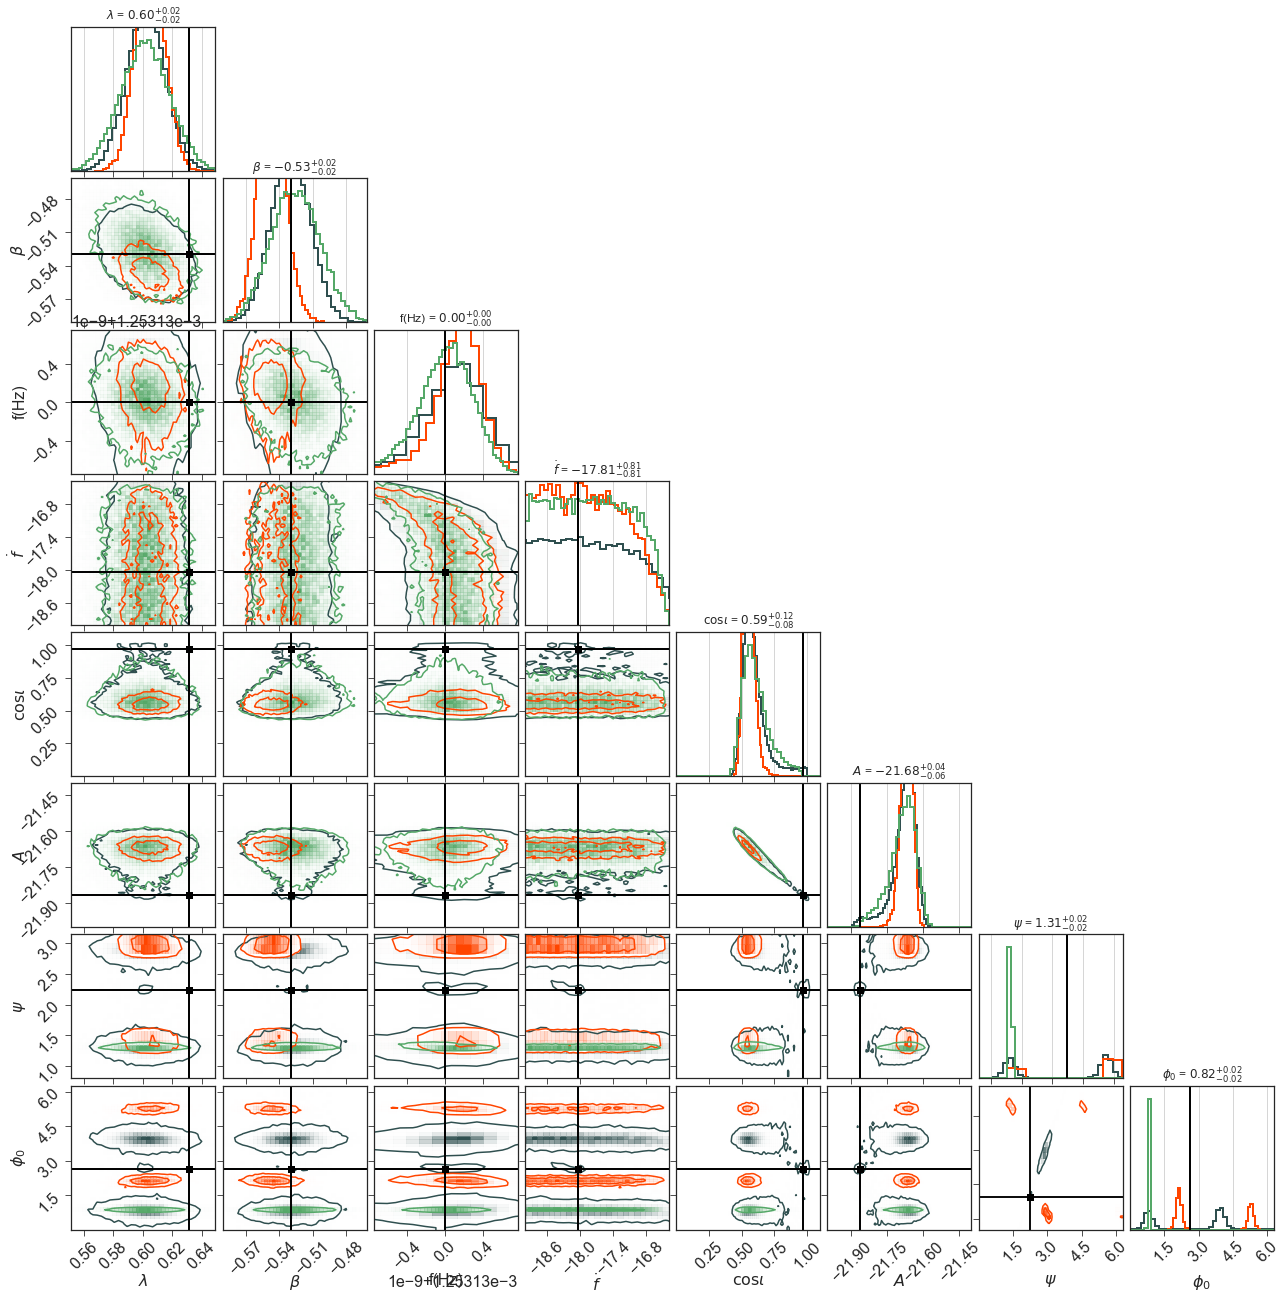

In [66]:
print (lbls)
# rng = [0.999, 0.999, 0.999, 0.999, (0, np.pi), (-22,-21.4), (0.8, np.pi), (0, 2*np.pi)]
rng = [0.999, 0.999, 0.999, 0.999, (0, 1.1), (-22,-21.4), (0.8, np.pi), (0, 2*np.pi)]


fig1 = corner.corner(datSt,  bins=40,  hist_kwargs={'density':True, 'lw':2},  plot_datapoints=False, labels=lbls,  show_titles=True, \
                        color='darkslategray', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.95], title_kwargs={"fontsize": 12})


corner.corner(datBc,  bins=40,  hist_kwargs={'density':True, 'lw':2}, fig=fig1, plot_datapoints=False, fill_contours=False,  labels=lbls,  show_titles=True, \
                        color='orangered', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.5,0.9], title_kwargs={"fontsize": 12})#, range=rng)

corner.corner(datETH,  bins=40,  hist_kwargs={'density':True, 'lw':2}, fig=fig1, plot_datapoints=False, fill_contours=False,  labels=lbls,  show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12}, range=rng)

plt.show()

### How I sample the data (not a search, seeding at true position)

this is  GW135962


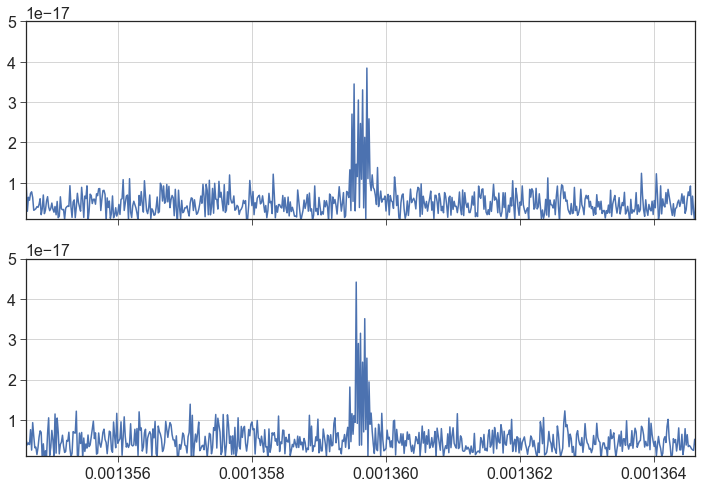

In [75]:
ind_0 = 0
ks = list(VGBs.keys())
print ('this is ', ks[ind_0])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)
# print (f0, Amp, fdot)
nm_pars1 = ['log10_Amp', 'fr', 'log10_fdot', 'sin_bet', 'lam', 'cos_iota', 'psi', 'phi0'] 
Npars = 8
x0 = np.array([np.log10(Amp), f0,  np.log10(fdot), np.sin(bet), lam+2.0*np.pi, np.cos(iota), psi, phi0])


fr_my_min = f0 - 5.e-6
fr_my_max = f0 + 5.e-6
prior = MakePrior1Src(f_fctr=1.e-3)

frac = 1  ### use 1/frac part of the data
Tobs = float(p.get("ObservationDuration"))/frac
df = 1.0/Tobs

freqD, DAf, DEf = GetFDdata(Tobs)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
ax[0].plot(freqD, np.abs(DAf))
ax[0].set_xlim([fr_my_min, fr_my_max])
ax[0].set_ylim([1.e-18, 5e-17])
# ax[0].set_xlim([4.e-5, 2.e-2])

ax[0].grid(True)
ax[1].plot(freqD, np.abs(DEf))
ax[1].set_ylim([1.e-18, 5e-17])
ax[1].grid(True)

fastGB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")


prm = np.array([f0, fdot, bet,  lam+2.0*np.pi,  Amp,  iota,  psi, -phi0])




#### Prepare sampler and sample

In [76]:
np.random.seed(0)
Nchains = 3
Nadapt = 1000
arg_harm= {'maxoff':8.0}
prop_args = {'cov' : None, 'DE_skip': 1000}
out_dir = './Results/'
Npars = 8

chainLength = 500000 ###
verbal=True

x_init = [x0, x0, x0] ### seeding at true location 

Ms = mcmc.MultiChain_MCMC(np.array(prior), Nchains, LikelihoodFlat, Nadapt, nm_pars1, 1 )
Ms.InitialPoints(x_init)
Ms.InitializeProposals([{'SCAM':70., 'DE':50, 'slice':40.}, \
                        {'SCAM':70., 'DE':50., 'slice':40.},\
                        {'SCAM':70., 'DE':50., 'slice':40.}], **prop_args)



chains = Ms.runMCMC(chainLength,  verbal)

  0%|          | 6/500000 [00:00<2:22:23, 58.53it/s]

0 current loglik -488.03483077656387 best -488.03483077656387
1 current loglik -488.03483077656387 best -488.03483077656387
2 current loglik -488.03483077656387 best -488.03483077656387
stas
0 current loglik -488.03483077656387 best -488.03483077656387
1 current loglik -488.03483077656387 best -488.03483077656387
2 current loglik -488.03483077656387 best -488.03483077656387
0 current loglik -488.03483077656387 best -488.03483077656387
1 current loglik -488.03483077656387 best -488.03483077656387
2 current loglik -488.03483077656387 best -488.03483077656387


  2%|▏         | 10010/500000 [01:33<1:01:47, 132.16it/s]

0 current loglik 94.13946166181731 best 97.17395550905948
1 current loglik 608.635810600234 best 610.1118428795693
2 current loglik 607.5895289294649 best 610.0976161918953


  4%|▍         | 19994/500000 [02:49<1:01:58, 129.09it/s]

0 current loglik 606.4448508963177 best 607.2498571757085
1 current loglik 606.37161799436 best 610.5488613931252
2 current loglik 606.3792806736504 best 610.5705695171064


  6%|▌         | 30004/500000 [03:56<1:03:11, 123.97it/s]

0 current loglik 605.0696541593214 best 609.7353433902856
1 current loglik 606.6560448789808 best 610.6170819366787
2 current loglik 608.0842615537641 best 610.5705695171064


  8%|▊         | 39994/500000 [05:00<45:54, 167.01it/s]  

0 current loglik 608.1328295619501 best 609.8797409353716
1 current loglik 606.7303610464492 best 610.6170819366787
2 current loglik 607.6763484002184 best 610.6816671395225


 10%|▉         | 49998/500000 [06:03<45:05, 166.35it/s]  

0 current loglik 607.1411003186139 best 610.1222844039169
1 current loglik 604.5633657953296 best 610.6170819366787
2 current loglik 606.2694679695768 best 610.6816671395225


 12%|█▏        | 59974/500000 [07:03<30:31, 240.20it/s]  

0 current loglik 609.0284546443158 best 610.2022001724087
1 current loglik 605.391149683956 best 610.6206772890467


 12%|█▏        | 60001/500000 [07:03<57:02, 128.56it/s]

2 current loglik 606.6860055987902 best 610.6816671395225


 14%|█▍        | 69998/500000 [08:07<43:36, 164.33it/s]  

0 current loglik 607.4911819777227 best 610.7447686382326
1 current loglik 605.332144592876 best 610.6671388270129
2 current loglik 608.6441921341768 best 610.6816671395225


 16%|█▌        | 79997/500000 [09:09<42:44, 163.78it/s]  

0 current loglik 608.3770990585576 best 610.7447686382326
1 current loglik 607.6537815305096 best 610.6671388270129
2 current loglik 605.7900767594359 best 610.6816671395225


 18%|█▊        | 89996/500000 [10:10<47:01, 145.31it/s]  

0 current loglik 605.7926032244849 best 610.7447686382326
1 current loglik 605.7449314581727 best 610.6671388270129
2 current loglik 605.5165733521778 best 610.6816671395225


 20%|█▉        | 99981/500000 [11:12<38:17, 174.13it/s]  

0 current loglik 607.750823751915 best 610.7447686382326
1 current loglik 608.4600463464427 best 610.6671388270129


 20%|██        | 100001/500000 [11:12<1:31:39, 72.73it/s]

2 current loglik 609.9280278074447 best 610.6816671395225


 22%|██▏       | 110000/500000 [12:16<37:37, 172.75it/s]  

0 current loglik 606.132333279638 best 610.7447686382326
1 current loglik 606.476655721834 best 610.6671388270129
2 current loglik 607.0931567526972 best 610.6816671395225


 24%|██▍       | 119999/500000 [13:17<36:58, 171.31it/s]  

0 current loglik 606.4603672568632 best 610.7447686382326
1 current loglik 606.8706897383714 best 610.6671388270129
2 current loglik 607.8875243889408 best 610.6816671395225


 26%|██▌       | 129984/500000 [14:18<34:40, 177.85it/s]  

0 current loglik 607.3942588984908 best 610.7447686382326
1 current loglik 605.5846244975297 best 610.6671388270129
2 current loglik 603.8841813455249 best 610.6816671395225


 28%|██▊       | 139988/500000 [15:21<37:01, 162.08it/s]  

0 current loglik 607.1578283182765 best 610.7447686382326
1 current loglik 608.4275341260026 best 610.6671388270129
2 current loglik 607.78932962464 best 610.6816671395225


 30%|██▉       | 149991/500000 [16:26<34:26, 169.35it/s] 

0 current loglik 606.7509609024245 best 610.7447686382326
1 current loglik 606.7125163974428 best 610.6671388270129
2 current loglik 605.698637676375 best 610.6816671395225


 32%|███▏      | 159990/500000 [17:30<27:43, 204.38it/s] 

0 current loglik 606.4524495184112 best 610.7447686382326
1 current loglik 607.9316802290474 best 610.6671388270129
2 current loglik 606.4001681983582 best 610.6816671395225


 34%|███▍      | 169980/500000 [18:36<27:42, 198.52it/s] 

0 current loglik 605.0470530794589 best 610.7447686382326
1 current loglik 608.2426798367785 best 610.6671388270129
2 current loglik 605.1808277990167 best 610.6816671395225


 36%|███▌      | 179986/500000 [19:45<31:03, 171.76it/s] 

0 current loglik 607.3777378812447 best 610.7447686382326
1 current loglik 608.2282148014111 best 610.6671388270129
2 current loglik 605.5744332167975 best 610.6816671395225


 38%|███▊      | 189988/500000 [20:50<31:09, 165.83it/s] 

0 current loglik 606.112226875586 best 610.7447686382326
1 current loglik 609.20167920049 best 610.6671388270129
2 current loglik 607.352960288221 best 610.6816671395225


 40%|███▉      | 199986/500000 [21:55<30:00, 166.66it/s] 

0 current loglik 606.1983771873764 best 610.7447686382326
1 current loglik 605.3126742418333 best 610.75970765158
2 current loglik 609.0489848214111 best 610.6816671395225


 42%|████▏     | 209986/500000 [22:58<20:19, 237.74it/s] 

0 current loglik 609.766960535828 best 610.7447686382326
1 current loglik 608.3884579258835 best 610.75970765158
2 current loglik 603.3659895488088 best 610.6816671395225


 44%|████▍     | 219994/500000 [23:55<20:44, 224.92it/s] 

0 current loglik 607.3475822471989 best 610.7447686382326
1 current loglik 607.9472081181444 best 610.75970765158
2 current loglik 606.7814734564383 best 610.6816671395225


 46%|████▌     | 229985/500000 [24:53<24:50, 181.15it/s] 

0 current loglik 608.4264853023444 best 610.7447686382326
1 current loglik 607.1280573153107 best 610.75970765158
2 current loglik 607.6772620170514 best 610.6816671395225


 48%|████▊     | 239981/500000 [25:52<19:22, 223.73it/s] 

0 current loglik 604.7456302194189 best 610.7447686382326
1 current loglik 609.1382629113758 best 610.75970765158
2 current loglik 607.8552968488098 best 610.6816671395225


 50%|████▉     | 249994/500000 [26:52<20:25, 203.95it/s] 

0 current loglik 605.7630670593661 best 610.7447686382326
1 current loglik 606.7068709739058 best 610.75970765158
2 current loglik 607.5599805033104 best 610.6816671395225


 52%|█████▏    | 259996/500000 [27:54<22:30, 177.72it/s] 

0 current loglik 605.8737845042118 best 610.7447686382326
1 current loglik 609.2358917868964 best 610.75970765158
2 current loglik 605.3995435747227 best 610.6816671395225


 54%|█████▍    | 269997/500000 [28:54<20:59, 182.60it/s] 

0 current loglik 609.3543134484678 best 610.7447686382326
1 current loglik 606.9364937311425 best 610.75970765158
2 current loglik 608.6903848457061 best 610.6816671395225


 56%|█████▌    | 279981/500000 [29:55<16:40, 220.00it/s] 

0 current loglik 607.097785435779 best 610.7447686382326
1 current loglik 608.3489419146001 best 610.75970765158
2 current loglik 606.8861801780612 best 610.6816671395225


 58%|█████▊    | 289993/500000 [30:55<17:18, 202.27it/s] 

0 current loglik 608.0880915218307 best 610.7447686382326
1 current loglik 606.4796444877771 best 610.75970765158
2 current loglik 606.2876637635806 best 610.6816671395225


 60%|█████▉    | 299989/500000 [31:56<21:55, 152.04it/s] 

0 current loglik 608.5678188750271 best 610.7447686382326
1 current loglik 607.8471228834242 best 610.75970765158
2 current loglik 608.7955158363723 best 610.6816671395225


 62%|██████▏   | 309978/500000 [32:58<13:01, 243.02it/s] 

0 current loglik 604.4968096575625 best 610.7447686382326
1 current loglik 609.9399728598648 best 610.75970765158
2 current loglik 606.5512046997578 best 610.6816671395225


 64%|██████▍   | 319999/500000 [33:59<14:38, 204.96it/s] 

0 current loglik 609.5499741325252 best 610.7447686382326
1 current loglik 604.0112847943969 best 610.75970765158
2 current loglik 604.8574999457777 best 610.6816671395225


 66%|██████▌   | 329998/500000 [35:02<15:27, 183.26it/s] 

0 current loglik 607.5548299208075 best 610.7447686382326
1 current loglik 609.1438666371873 best 610.75970765158
2 current loglik 608.8415944509668 best 610.6816671395225


 68%|██████▊   | 339990/500000 [36:05<12:33, 212.41it/s] 

0 current loglik 607.752942155554 best 610.7447686382326
1 current loglik 605.549784984851 best 610.75970765158
2 current loglik 607.0685479474748 best 610.6816671395225


 70%|██████▉   | 349994/500000 [37:08<11:12, 223.05it/s] 

0 current loglik 608.8255833220927 best 610.7447686382326
1 current loglik 605.704537631183 best 610.75970765158
2 current loglik 609.4004164119528 best 610.6816671395225


 72%|███████▏  | 359979/500000 [38:14<12:25, 187.91it/s] 

0 current loglik 605.2341681642126 best 610.7447686382326
1 current loglik 608.2959485098525 best 610.75970765158
2 current loglik 602.7078843709418 best 610.6816671395225


 74%|███████▍  | 369985/500000 [39:20<12:00, 180.57it/s] 

0 current loglik 604.543136507478 best 610.7447686382326
1 current loglik 607.8310983194377 best 610.75970765158
2 current loglik 606.2235036951333 best 610.6816671395225


 76%|███████▌  | 379989/500000 [40:25<08:46, 227.91it/s] 

0 current loglik 606.9530842212912 best 610.7447686382326
1 current loglik 608.6566930387188 best 610.75970765158
2 current loglik 603.199034250634 best 610.6816671395225


 78%|███████▊  | 389984/500000 [41:31<09:45, 187.78it/s]

0 current loglik 607.294920653047 best 610.7447686382326
1 current loglik 607.6678123629464 best 610.75970765158
2 current loglik 604.941673123041 best 610.6816671395225


 80%|███████▉  | 399996/500000 [42:41<15:07, 110.18it/s] 

0 current loglik 608.0298150415156 best 610.7447686382326
1 current loglik 608.0236114148993 best 610.75970765158
2 current loglik 607.8339244731839 best 610.6816671395225


 82%|████████▏ | 409990/500000 [44:01<09:33, 156.85it/s] 

0 current loglik 607.4267118441529 best 610.7447686382326
1 current loglik 607.5893043443815 best 610.75970765158
2 current loglik 605.8121850281728 best 610.6816671395225


 84%|████████▍ | 419990/500000 [45:13<07:47, 170.96it/s] 

0 current loglik 607.9654635605008 best 610.7447686382326
1 current loglik 604.6925498567059 best 610.75970765158
2 current loglik 608.4517449631766 best 610.6816671395225


 86%|████████▌ | 429986/500000 [46:25<06:22, 183.17it/s]

0 current loglik 608.7206544227486 best 610.7447686382326
1 current loglik 606.598623230231 best 610.75970765158
2 current loglik 607.7905783572714 best 610.6816671395225


 88%|████████▊ | 439993/500000 [47:35<05:40, 176.16it/s]

0 current loglik 606.9492510446842 best 610.7447686382326
1 current loglik 608.6411364228245 best 610.75970765158
2 current loglik 608.6779147515122 best 610.6816671395225


 90%|████████▉ | 449998/500000 [48:47<04:31, 183.99it/s]

0 current loglik 610.1378313367975 best 610.7447686382326
1 current loglik 606.5346118775102 best 610.75970765158
2 current loglik 606.2998018942843 best 610.6816671395225


 92%|█████████▏| 459994/500000 [50:00<03:12, 208.12it/s]

0 current loglik 606.1972488697262 best 610.7447686382326
1 current loglik 604.3363245003604 best 610.7617664303359
2 current loglik 606.9050293415155 best 610.7589022913032


 94%|█████████▍| 469995/500000 [51:12<03:11, 156.44it/s]

0 current loglik 605.0223451279811 best 610.7447686382326
1 current loglik 606.8669893629307 best 610.7617664303359
2 current loglik 609.429613214637 best 610.7589022913032


 96%|█████████▌| 479983/500000 [52:25<01:43, 194.10it/s]

0 current loglik 605.0642189649601 best 610.7447686382326
1 current loglik 609.2645529843961 best 610.7617664303359
2 current loglik 609.3551681131912 best 610.7589022913032


 98%|█████████▊| 489985/500000 [53:38<00:46, 215.28it/s]

0 current loglik 607.5277674488087 best 610.7447686382326
1 current loglik 608.4693762722642 best 610.7617664303359
2 current loglik 605.0021181389909 best 610.7589022913032


100%|██████████| 500000/500000 [54:54<00:00, 151.76it/s]


statistics


 chain  0
SCAM 218713 9601
DE 155204 10940
slice 124855 efficiency 0.09750983064349225

 chain  1
SCAM 219950 9306
DE 154488 17653
slice 124316 efficiency 0.09699752114671738

 chain  2
SCAM 219122 9153
DE 154612 15922
slice 125024 efficiency 0.09743704047770835


In [89]:
chnS = np.array(chains[0].chn[100000::50])
chnS = np.concatenate((chnS, np.array(chains[1].chn[100000::50])))
chnS = np.concatenate((chnS, np.array(chains[2].chn[100000::50])))

print (np.shape(chnS))

# plt.plot(chnS[:, 1], '.')
# plt.show()

(23928, 8)


In [93]:
nm = 'GW135962'

datSt = np.zeros((len(chnS), len(lbls)))
datSt[:,0] = chnS[:,4]-np.pi
datSt[:,1] = np.arcsin(chnS[:, 3])
datSt[:,2] = chnS[:, 1]
datSt[:,3] = chnS[:, 2]
# datSt[:,4] = np.pi-np.arccos(chSt[:, 5])
datSt[:,4] =chnS[:, 5]
datSt[:,5] = chnS[:, 0]
datSt[:, 6] = chnS[:, 6]
datSt[:, 7] =  chnS[:, 7]

ind = VGBs[nm]['BC']
# lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\iota$', r'$A$', r'$\psi$', r'$\phi_0$']
lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\cos{\iota}$', r'$A$', r'$\psi$', r'$\phi_0$']

datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude'] + np.pi
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
# datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 4] = np.cos(Barc_data[ind]['Inclination'])
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])
datBc[:, 6] = Barc_data[ind]['Polarization']
datBc[:, 7] = Barc_data[ind]['InitialPhase']

dat = ETH_data[nm]

datETH = np.zeros((len(dat), len(lbls)))
datETH[:, 0] = dat['EclipticLongitude'] + np.pi
datETH[:, 1] = dat['EclipticLatitude']
datETH[:, 2] = dat['Frequency']
datETH[:, 3] = np.log10(np.abs(dat['FrequencyDerivative']))
# datETH[:, 4] = np.arccos(np.cos(dat['Inclination']))
datETH[:, 4] = np.cos(dat['Inclination'])
datETH[:, 5] = np.log10(dat['Amplitude'])
datETH[:, 6] = dat['Polarization']
datETH[:, 7] = dat['InitialPhase']

ind_0 = 0
bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

# tr_s = np.array([lam+np.pi, bet, f0, np.log10(fdot), np.arccos(np.cos(iota)), np.log10(Amp), psi, phi0])
tr_s = np.array([lam+np.pi, bet, f0, np.log10(fdot), np.cos(iota), np.log10(Amp), psi, phi0])
print ("true params", tr_s)




true params [ 3.88682654e-01  3.12414000e-01  1.35962000e-03 -1.80483802e+01
  8.66025292e-01 -2.19692182e+01  3.56216560e+00  3.05815650e+00]


ValueError: Contour levels must be increasing

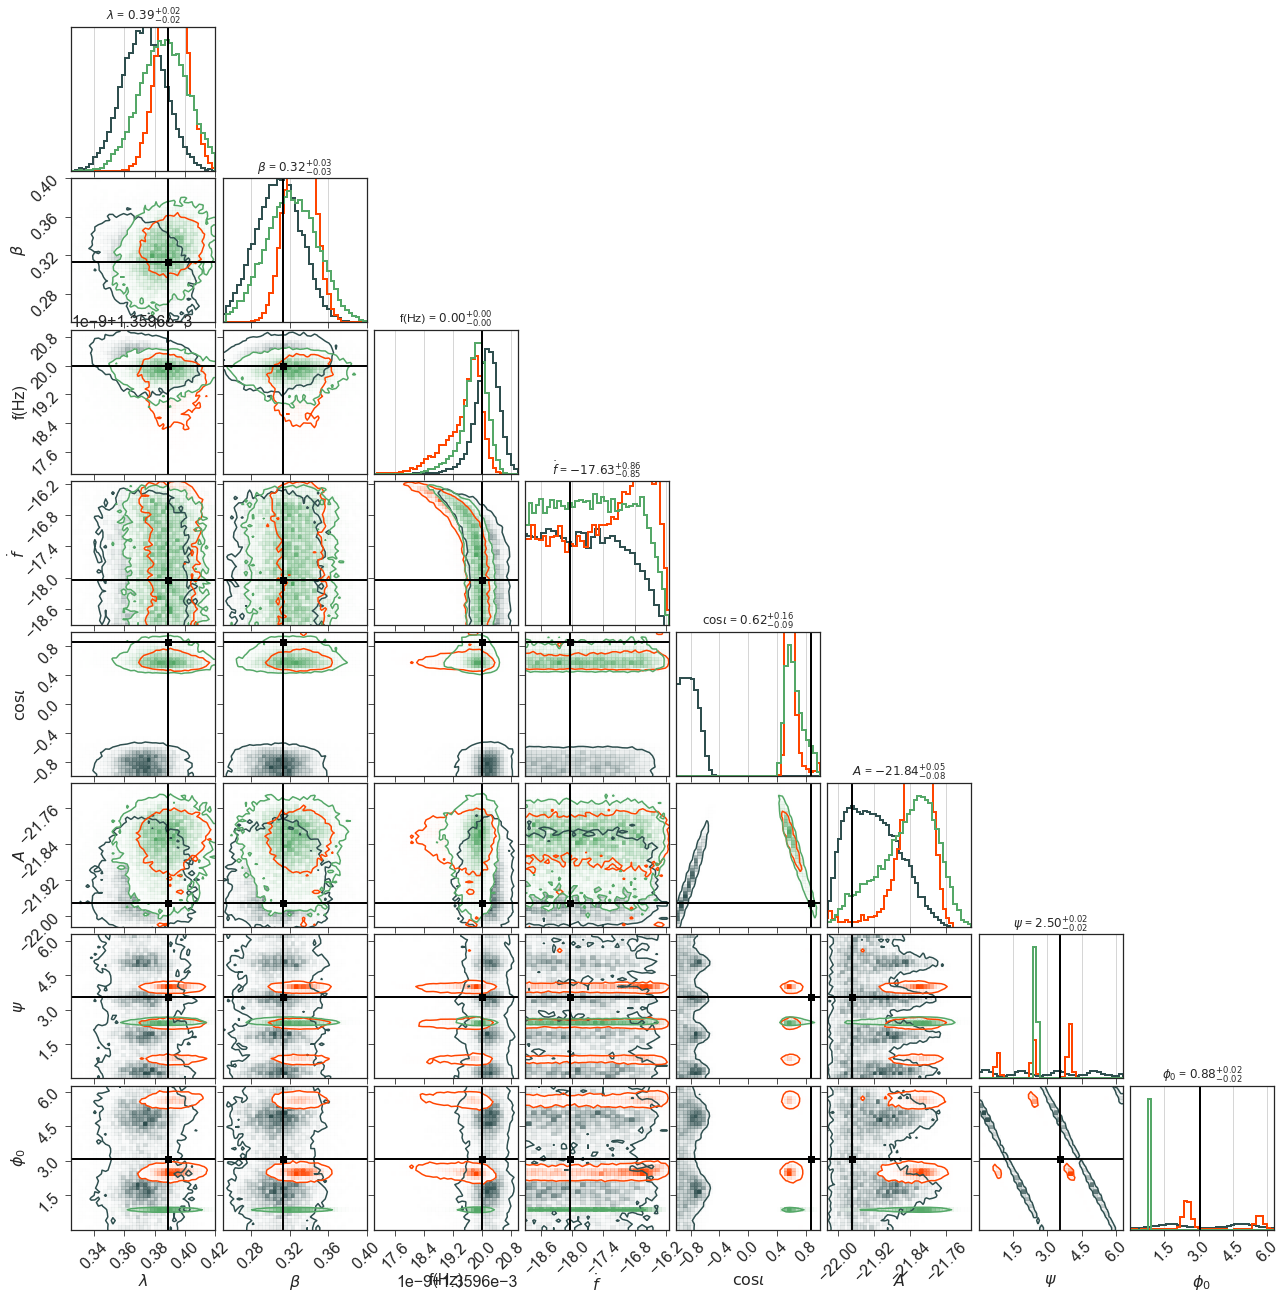

In [113]:
rng = [(0.325, 0.42), (0.25, 0.4), ( 1.35962000e-03 -3.0e-9,  1.35962000e-03 + 1.e-9), 0.999, (-1, 1), 0.999, (0., 2*np.pi), (0, 2*np.pi)]
# rng = [(0.325, 0.42), (0.25, 0.4), 0.999, (-18,-16.5), (0.1, 1.2), (-22.4, -21.6), (0, 2.0*np.pi), (0, 2.0*np.pi)]

fig2 = corner.corner(datSt,  bins=40,  hist_kwargs={'density':True, 'lw':2},  plot_datapoints=False, labels=lbls,  show_titles=True, \
                        color='darkslategray', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.95], title_kwargs={"fontsize": 12}, range = rng)


corner.corner(datBc,  bins=40,  hist_kwargs={'density':True, 'lw':2}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls,  show_titles=True, \
                        color='orangered', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12}, range=rng)

corner.corner(datETH,  bins=40,  hist_kwargs={'density':True, 'lw':2}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls,  show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12}, range=rng)

plt.show()